## Segunda vuelta

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import dirichlet, gamma

In [26]:
df2 = pd.read_excel('Datos_2vuelta.xlsx', sheet_name='Datos_por_dia_2v')
print(df2)

        Fecha    N  Nkast  Nboric
0  2021-09-16  709    191     355
1  2021-09-17    0      0       0
2  2021-09-18    0      0       0
3  2021-09-19    0      0       0
4  2021-09-20    0      0       0
..        ...  ...    ...     ...
91 2021-12-15    0      0       0
92 2021-12-16    0      0       0
93 2021-12-17    0      0       0
94 2021-12-18    0      0       0
95 2021-12-19    0      0       0

[96 rows x 4 columns]


In [27]:
datos2vuelta = df2.to_numpy()[:, 2:]
datos2vuelta = np.array(datos2vuelta, dtype=int)

### Modelo 1:
Distribución de prueba: $Gamma(500\times\alpha_{ti}+y_{ti}, 1)$

In [6]:
def modelo1(data, N):
    post = lambda p, alpha: dirichlet.logpdf(p, alpha)
    prueba = lambda alpha: np.array([gamma.rvs(a) for a in alpha])
    days = np.size(data, 0)
    cand = np.size(data, 1)
    muestra = np.zeros((N, days, cand))
    prior = np.full(cand, 1/cand)
    c = np.zeros(days)
    for i in range(N):
        for day in range(days):
            if day == 0:
                p = prior 
            else:
                p = muestra[i, day-1]
            y = data[day]
            alpha = y + 500 * p
            p_prueba = prueba(alpha)
            p_prueba = p_prueba / p_prueba.sum()
            metrop = post(p_prueba, alpha) - post(p, alpha)
            if min(metrop, 0) > np.log(np.random.uniform()):
                muestra[i, day] = p_prueba
                c[day] += 1
            else:
                muestra[i, day] = p
    return muestra, c
            

In [10]:
np.random.seed(567)
muestra1, c1 = modelo1(datos2vuelta, 10_000)
muestra1 = muestra1[1000::100]

In [9]:
prop = muestra1.mean(0)
days = np.size(prop, 0)
std = np.std(muestra1, axis=0)
q = [0.05, 0.95]
q1, q2 = np.quantile(muestra1, q, axis=0)
for i in range(days):
    print('aceptados dia {}: {:%}'.format(i+1, c1[i]/10_000))

aceptados dia 1: 100.000000%
aceptados dia 2: 71.350000%
aceptados dia 3: 71.010000%
aceptados dia 4: 71.210000%
aceptados dia 5: 70.710000%
aceptados dia 6: 70.610000%
aceptados dia 7: 70.500000%
aceptados dia 8: 70.660000%
aceptados dia 9: 71.020000%
aceptados dia 10: 70.020000%
aceptados dia 11: 70.860000%
aceptados dia 12: 70.820000%
aceptados dia 13: 71.100000%
aceptados dia 14: 70.960000%
aceptados dia 15: 70.940000%
aceptados dia 16: 94.050000%
aceptados dia 17: 71.550000%
aceptados dia 18: 71.020000%
aceptados dia 19: 69.570000%
aceptados dia 20: 70.600000%
aceptados dia 21: 70.930000%
aceptados dia 22: 95.830000%
aceptados dia 23: 70.850000%
aceptados dia 24: 70.350000%
aceptados dia 25: 71.280000%
aceptados dia 26: 70.400000%
aceptados dia 27: 70.760000%
aceptados dia 28: 71.150000%
aceptados dia 29: 83.490000%
aceptados dia 30: 89.880000%
aceptados dia 31: 71.300000%
aceptados dia 32: 70.850000%
aceptados dia 33: 70.410000%
aceptados dia 34: 70.940000%
aceptados dia 35: 70.4

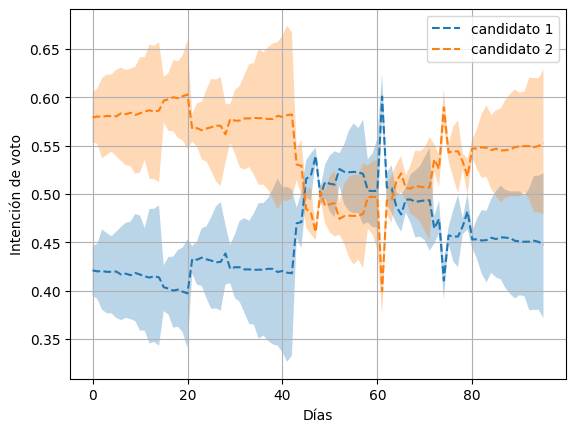

In [10]:
for i in range(2):
    plt.plot(range(days), prop[:,i], '--', label= 'candidato {}'.format(i+1))
    plt.fill_between(range(days), q1[:,i], q2[:,i],alpha=0.3)
plt.xlabel("Días")
plt.ylabel("Intención de voto")
plt.grid()
plt.legend()

In [11]:
pred = prop[-1]
print('Kast: {:%}'.format(pred[0]))
print('Boric: {:%}'.format(pred[1]))

Kast: 44.726163%
Boric: 55.273837%


### Modelo 2:
Distribución de prueba: $Unif(\max\{(500\alpha_{t-1,i}+y_{ti})-d,0\},(500\alpha_{t-1,i}+y_{ti})+d)$

$d=10$

In [13]:
def modelo2(data, N, d):
    post = lambda p, alpha: dirichlet.logpdf(p, alpha)
    days = np.size(data, axis=0)
    cand = np.size(data, axis=1)
    prueba = lambda alpha, d: np.random.randint(np.maximum(alpha-d,0),alpha+d, size=cand)
    muestra = np.zeros((N, days, cand))
    prior = np.full(cand, 1/cand)
    c = np.zeros(days)
    for i in range(N):
        for day in range(days):
            if day == 0:
                p = prior
            else:
                p = muestra[i, day-1]
            y = data[day]
            alpha = 500 * p + y
            p_prueba = prueba(alpha, d)
            p_prueba = p_prueba/p_prueba.sum()
            if post(p_prueba, alpha) - post(p, alpha) > np.log(np.random.uniform()):
                muestra[i, day] = p_prueba
                c[day] += 1
            else:
                muestra[i, day] = p
    return muestra, c

In [16]:
np.random.seed(834)
muestra2, c2 = modelo2(datos2vuelta, 10_000, d=10)
muestra2 = muestra2[1000::100]

In [17]:
prop = muestra2.mean(0)
days = np.size(prop, 0)
q = [0.05, 0.95]
q1, q2 = np.quantile(muestra2, q, axis=0)
for i in range(days):
    print('aceptados dia {}: {:%}'.format(i+1, c2[i]/10_000))

aceptados dia 1: 100.000000%
aceptados dia 2: 94.120000%
aceptados dia 3: 93.360000%
aceptados dia 4: 93.550000%
aceptados dia 5: 93.900000%
aceptados dia 6: 93.670000%
aceptados dia 7: 93.370000%
aceptados dia 8: 93.640000%
aceptados dia 9: 92.890000%
aceptados dia 10: 93.360000%
aceptados dia 11: 93.380000%
aceptados dia 12: 93.430000%
aceptados dia 13: 93.200000%
aceptados dia 14: 92.850000%
aceptados dia 15: 92.980000%
aceptados dia 16: 99.910000%
aceptados dia 17: 92.920000%
aceptados dia 18: 93.720000%
aceptados dia 19: 93.170000%
aceptados dia 20: 93.690000%
aceptados dia 21: 93.400000%
aceptados dia 22: 99.990000%
aceptados dia 23: 93.860000%
aceptados dia 24: 93.300000%
aceptados dia 25: 93.450000%
aceptados dia 26: 93.510000%
aceptados dia 27: 93.580000%
aceptados dia 28: 93.840000%
aceptados dia 29: 99.370000%
aceptados dia 30: 99.960000%
aceptados dia 31: 93.440000%
aceptados dia 32: 93.540000%
aceptados dia 33: 93.350000%
aceptados dia 34: 93.700000%
aceptados dia 35: 93.3

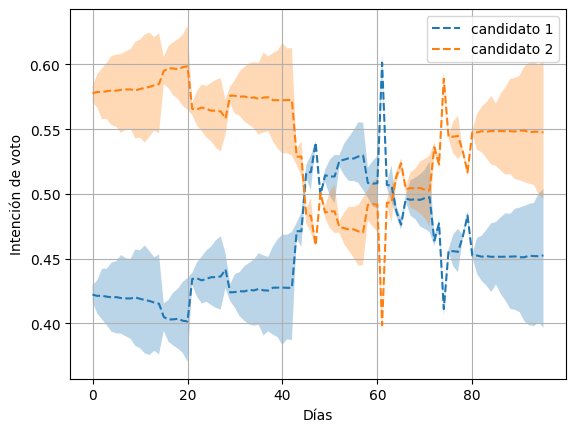

In [18]:
for i in range(2):
    plt.plot(range(days), prop[:,i], '--', label= 'candidato {}'.format(i+1))
    plt.fill_between(range(days), q1[:,i], q2[:,i],alpha=0.3)
plt.xlabel("Días")
plt.ylabel("Intención de voto")
plt.grid()
plt.legend();

In [20]:
pred = prop[-1]
print('Kast: {:%}'.format(pred[0]))
print('Boric: {:%}'.format(pred[1]))

Kast: 45.250688%
Boric: 54.749312%


$d=50$

In [21]:
np.random.seed(789)
muestra3, c3 = modelo2(datos2vuelta, 10_000, d=50)
muestra3 = muestra3[1000::100]

In [22]:
prop = muestra3.mean(0)
days = np.size(prop, 0)
q = [0.05, 0.95]
q1, q2 = np.quantile(muestra3, q, axis=0)
for i in range(days):
    print('aceptados dia {}: {:%}'.format(i+1, c3[i]/10_000))

aceptados dia 1: 100.000000%
aceptados dia 2: 43.550000%
aceptados dia 3: 43.950000%
aceptados dia 4: 44.030000%
aceptados dia 5: 44.720000%
aceptados dia 6: 44.320000%
aceptados dia 7: 43.730000%
aceptados dia 8: 43.620000%
aceptados dia 9: 44.610000%
aceptados dia 10: 43.390000%
aceptados dia 11: 44.910000%
aceptados dia 12: 43.370000%
aceptados dia 13: 42.610000%
aceptados dia 14: 44.250000%
aceptados dia 15: 43.650000%
aceptados dia 16: 95.080000%
aceptados dia 17: 43.110000%
aceptados dia 18: 43.870000%
aceptados dia 19: 43.360000%
aceptados dia 20: 43.430000%
aceptados dia 21: 42.120000%
aceptados dia 22: 98.640000%
aceptados dia 23: 43.790000%
aceptados dia 24: 44.110000%
aceptados dia 25: 44.420000%
aceptados dia 26: 43.680000%
aceptados dia 27: 44.080000%
aceptados dia 28: 44.440000%
aceptados dia 29: 73.530000%
aceptados dia 30: 88.960000%
aceptados dia 31: 43.740000%
aceptados dia 32: 44.350000%
aceptados dia 33: 43.630000%
aceptados dia 34: 44.480000%
aceptados dia 35: 43.5

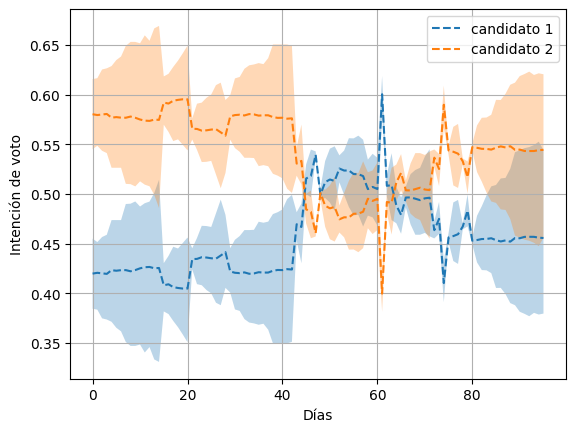

In [24]:
for i in range(2):
    plt.plot(range(days), prop[:,i], '--', label= 'candidato {}'.format(i+1))
    plt.fill_between(range(days), q1[:,i], q2[:,i],alpha=0.3)
plt.xlabel("Días")
plt.ylabel("Intención de voto")
plt.grid()
plt.legend();

In [25]:
pred = prop[-1]
print('Kast: {:%}'.format(pred[0]))
print('Boric: {:%}'.format(pred[1]))

Kast: 45.566872%
Boric: 54.433128%


$d=25$

In [28]:
np.random.seed(789)
muestra4, c4 = modelo2(datos2vuelta, 10_000, d=25)
muestra4 = muestra4[1000::100]

In [33]:
prop = muestra4.mean(0)
days = np.size(prop, 0)
q = [0.05, 0.95]
q1, q2 = np.quantile(muestra4, q, axis=0)
for i in range(days):
    print('aceptados dia {}: {:%}'.format(i+1, c4[i]/10_000))

aceptados dia 1: 100.000000%
aceptados dia 2: 71.010000%
aceptados dia 3: 70.720000%
aceptados dia 4: 70.250000%
aceptados dia 5: 70.890000%
aceptados dia 6: 70.860000%
aceptados dia 7: 70.750000%
aceptados dia 8: 70.690000%
aceptados dia 9: 71.200000%
aceptados dia 10: 70.160000%
aceptados dia 11: 71.170000%
aceptados dia 12: 71.020000%
aceptados dia 13: 71.200000%
aceptados dia 14: 70.770000%
aceptados dia 15: 71.300000%
aceptados dia 16: 99.240000%
aceptados dia 17: 70.490000%
aceptados dia 18: 70.440000%
aceptados dia 19: 71.160000%
aceptados dia 20: 70.620000%
aceptados dia 21: 71.640000%
aceptados dia 22: 99.800000%
aceptados dia 23: 71.210000%
aceptados dia 24: 70.340000%
aceptados dia 25: 71.610000%
aceptados dia 26: 70.890000%
aceptados dia 27: 70.850000%
aceptados dia 28: 72.210000%
aceptados dia 29: 93.550000%
aceptados dia 30: 98.140000%
aceptados dia 31: 70.710000%
aceptados dia 32: 70.730000%
aceptados dia 33: 71.010000%
aceptados dia 34: 71.400000%
aceptados dia 35: 71.4

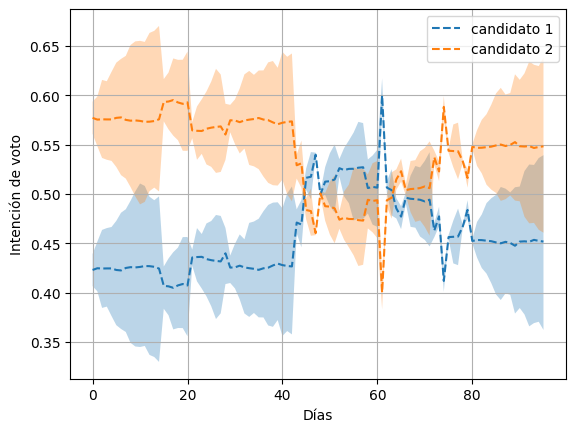

In [30]:
for i in range(2):
    plt.plot(range(days), prop[:,i], '--', label= 'candidato {}'.format(i+1))
    plt.fill_between(range(days), q1[:,i], q2[:,i],alpha=0.3)
plt.xlabel("Días")
plt.ylabel("Intención de voto")
plt.grid()
plt.legend();

In [32]:
pred = prop[-1]
print('Kast: {:%}'.format(pred[0]))
print('Boric: {:%}'.format(pred[1]))

Kast: 45.173416%
Boric: 54.826584%


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d24ecb2b-b17d-41bb-82ac-38080033d82c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>